In [21]:
import numpy as np
import librosa
from IPython.display import Audio, display
from matplotlib import pyplot as plt
import soundfile as sf
import scipy


import sys
import os
# Add upper directory
current_dir = os.path.dirname(os.path.abspath('lpa.ipynb'))
upper_dir = (os.path.join(current_dir, '..'))
sys.path.append(upper_dir)
from utils_global import draw_spec, audioshow, extract_frames, lpf, VisualizeFrames
from HW3.mystft import stft, istft, overlapadd
from mylpc import *

### Frame-Wise Linear Predictive Analysis

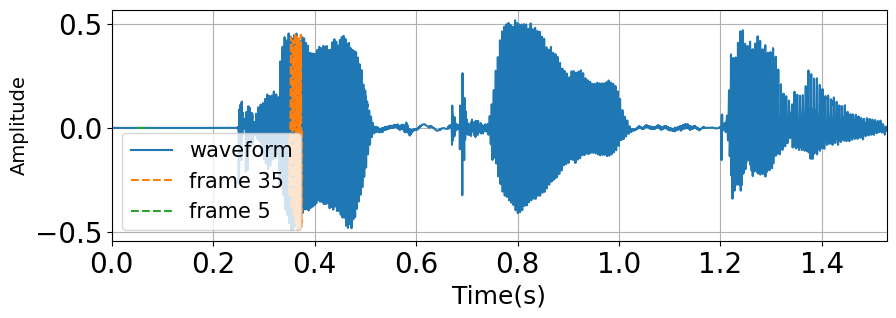

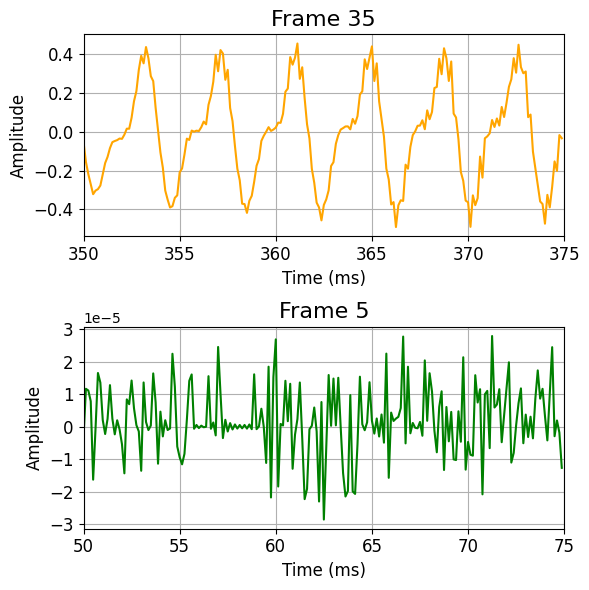

In [22]:
y, sr = librosa.load("/home/woongjib/Projects/24-2_SSP/HW3/s5_001_mic1.flac", sr=8000)
frames = extract_frames(y, sr=8000, win_type='hamming', win_length=200, hop_length=80) # 251 frames
VisualizeFrames(y, sr, win_length=200, hop_length=80, frame_indices=[35, 5], win_type="rectangular", figsize=(10,3))
display(Audio(frames[110], rate=sr))

# t = auto_corr(frames[35])
# plt.plot(t)

In [23]:
## LP Analysis in single frame
for order in [4]:
    a = librosa.lpc(y, order=order)
    print("Librosa.LPC original:", a)
    
    mya, err = LPC(y, order=order) #Matrix Inverse
    drbina, e1 = ref_derbin(auto_corr(y), order=order) #Derbin's Inverse
    mydrbina, e2 = derbin(auto_corr(y), p=order) #Implemented Derbin's Algorithm

    print("librosa LPC: \t\t", -1 * a[1:5])  
    print("Matrix Inverse: \t", mya[:4])      
    print("Derbin's Inverse: \t", drbina[:4])  
    print("myDerbin's Inverse: \t", mydrbina[:4])  

    print("LPC error: \t", err[:4])  
    print("Derbin error: \t", e1[:4])  
    print("my error: \t", e2[:4])  

    print(np.mean(err**2))
    print('\n')

    print(len(err))

Librosa.LPC original: [ 1.         -1.009134   -0.16773388  0.00589651  0.35661128]
librosa LPC: 		 [ 1.009134    0.16773388 -0.00589651 -0.35661128]
Matrix Inverse: 	 [ 1.00914525  0.16770998 -0.00589578 -0.35659754]
Derbin's Inverse: 	 [ 1.00914525  0.16770998 -0.00589578 -0.35659754]
myDerbin's Inverse: 	 [ 1.00914525  0.16770998 -0.00589578 -0.35659754]
LPC error: 	 [180.39175415  23.36811722  18.86583303  15.55308937]
Derbin error: 	 [180.39175415  23.36811722  18.86583303  15.55308937]
my error: 	 [180.39175415  23.36811722  18.86583303  15.55308937]
6773.872341953395


5


gain: 0.3341456781166947


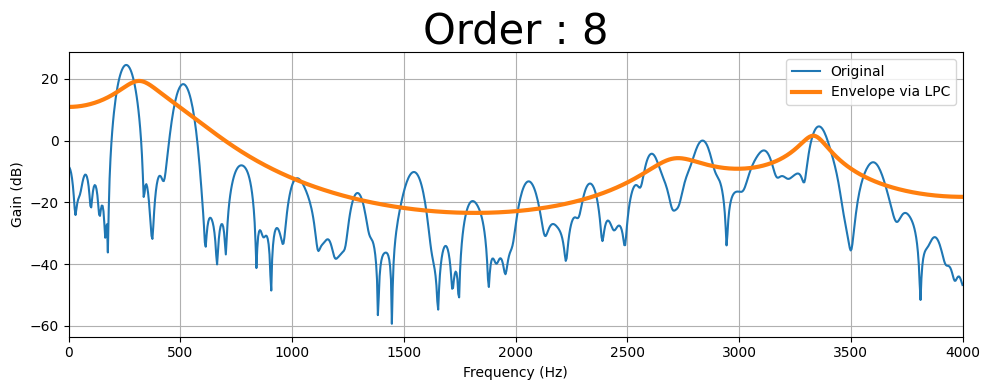

gain: 0.023088111184853367


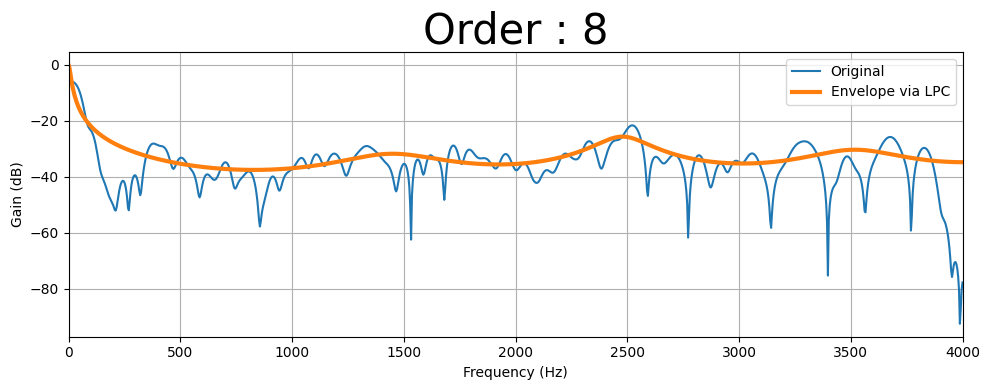

In [24]:
## Estimate of Vocal Tract using LP coefficients
PlotLPCSpectrum(frames[35],sr=sr,p=8,dftlen=2048, figsize=(10,4))
PlotLPCSpectrum(frames[110],sr=sr,p=8,dftlen=2048, figsize=(10,4))

### Waveform Synthesis via LPC

In [5]:
from HW3.ste_zcr import ste, zcr, vad
ste_arr = ste(frames)
zcr_arr = zcr(frames)
vad_arr = vad(ste_arr, frame_duration=15)

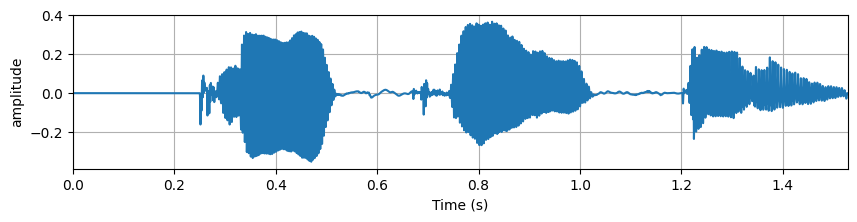

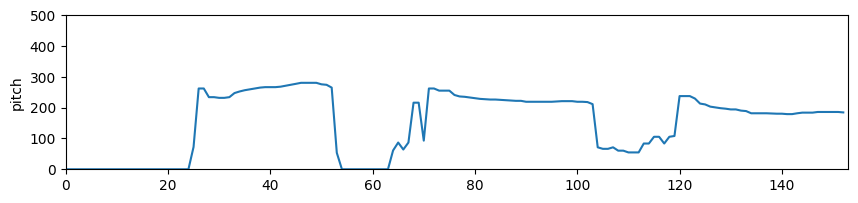

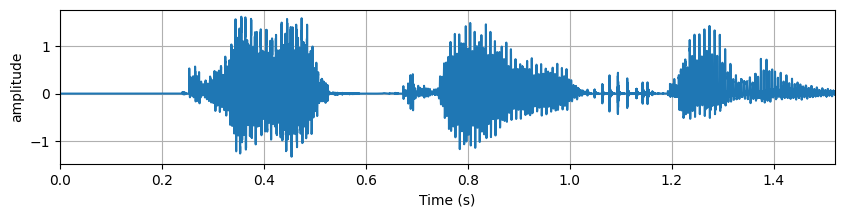

In [20]:
from HW3.pitchestimate import pitch_estimate_ac, pitch_estimate_amdf
from HW3.ste_zcr import vad

y, sr = librosa.load("/home/woongjib/Projects/24-2_SSP/HW3/sample_crop_16kHz.wav", sr=8000)
y, sr = librosa.load("/home/woongjib/Projects/24-2_SSP/SATEST/yonseicrop.wav", sr=16000)
y, sr = librosa.load("/home/woongjib/Projects/24-2_SSP/HW3/s5_180_mic1.flac", sr=16000)
y, sr = librosa.load("/home/woongjib/Projects/24-2_SSP/HW3/s5_001_mic1.flac", sr=48000)
display(Audio(y, rate=sr))

win_length = int(sr * 20 / 1000) # 320
hop_length = int(sr * 10 / 1000) # 160

################### LP Analysis
frames = extract_frames(y, sr=sr, win_type='hamming', win_length=win_length, hop_length=hop_length) # 251 frames
lpc, gain = lp_analysis(frames, 4)
lpc_2, gain_2 = lp_analysis(frames, 16)
lpc_3, gain_3 = lp_analysis(frames, 64)

################### Pitch Estimation
y_lpf = lpf(y,sr=sr, cutoff=500)
audioshow(y_lpf,sr, figsize=(10,2))
vadlist = vad(ste(frames), frame_duration=15)
pitchlist = pitch_estimate_ac(y_lpf, sr=sr, vad_arr=vadlist, win_length=win_length, hop_length=hop_length)
# pitchlist = pitch_estimate_amdf(y_lpf, sr=sr, vad_arr=vadlist, win_length=win_length, hop_length=hop_length)
pitchlist = scipy.signal.medfilt(pitchlist,kernel_size=5)
# voiced_flag, pitchlist = PitchDetector(frames, sr=sr)
plt.figure(figsize=(10.1,2))
plt.plot(pitchlist)
plt.ylim(0,500)
plt.ylabel('pitch')
plt.xlim(0, len(pitchlist))
plt.show()

# audioshow(gain, sr=sr, figsize=(10,2))
###################

start=0
y = SynthesizeWaveform(lpc, gain, pitchlist, sr=sr, win_length=win_length, hop_length=hop_length, printflag=False)    
# audioshow(y[start:],sr, figsize=(10,2))
display(Audio(y[start:], rate=sr))

y = SynthesizeWaveform(lpc_2, gain_2, pitchlist, sr=sr, win_length=win_length, hop_length=hop_length)    
# audioshow(y[start:],sr, figsize=(10,2))
display(Audio(y[start:], rate=sr))

yy = SynthesizeWaveform(lpc_3, gain_3, pitchlist, sr=sr, win_length=win_length, hop_length=hop_length)    
display(Audio(yy[start:], rate=sr))

# No align
y = SynthesizeWaveform(lpc_3, gain_3, pitchlist, sr=sr, win_length=win_length, hop_length=hop_length, align_impulse=False)    
# y = overlapadd(y, win_length=win_length, hop_length=hop_length, win_type='rectangular', griffin=True)
display(Audio(y[:], rate=sr))

audioshow(yy[:],sr, figsize=(10,2))

### Utils